# Summary


In [1]:
#Install Packages
!pip install app-store-scraper
!pip install wordcloud

#Import Libraries
from app_store_scraper import AppStore

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
import json,os,uuid
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
      Successfully uninstalled idna-3.4
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [25]:
#Collect all the ChatGPT reviews from App Store
a_reviews = AppStore('us','binge',' ')
a_reviews.review(sleep=1)

In [26]:
data = pd.DataFrame(np.array(a_reviews.reviews),columns=['review'])
data = data.join(pd.DataFrame(data.pop('review').tolist()))
data.head()

,date,developerResponse,review,rating,isEdited,title,userName
0,2023-02-13 06:37:24,"{'id': 35688295, 'body': 'Thank you for your k...",I recently switched to Microsoft Edge and Bing...,5,False,Amazing experience with Microsoft ecosystem,Santo_View
1,2023-10-17 11:03:32,NaN,"I’ll make this short and simple, most people p...",3,False,COULD be the greatest Ai image app… here’s why...,Mr. Fortnite hater
2,2023-08-12 00:22:35,NaN,This app has been great. Having the help from ...,4,False,This app. is so slick it doesn’t need grease,CTG369
3,2023-08-23 23:21:00,NaN,I use this app a lot. I mainly use the creativ...,2,False,Ehh,minimums how's
4,2023-08-16 11:54:44,NaN,As a retired professional when this whole AI c...,5,False,Great App and great company to back it up.,ckava4


In [27]:
data.shape

(140, 7)

In [28]:
data.drop(['isEdited','userName','developerResponse'],axis=1,inplace=True) #Delete columns
data = data[['date','title','review','rating']] #Rearrange columns
data.head()

,date,title,review,rating
0,2023-02-13 06:37:24,Amazing experience with Microsoft ecosystem,I recently switched to Microsoft Edge and Bing...,5
1,2023-10-17 11:03:32,COULD be the greatest Ai image app… here’s why...,"I’ll make this short and simple, most people p...",3
2,2023-08-12 00:22:35,This app. is so slick it doesn’t need grease,This app has been great. Having the help from ...,4
3,2023-08-23 23:21:00,Ehh,I use this app a lot. I mainly use the creativ...,2
4,2023-08-16 11:54:44,Great App and great company to back it up.,As a retired professional when this whole AI c...,5


In [29]:
data.to_excel('binge_reviews.xlsx', index=False)

In [30]:
data.to_csv('binge_reviews.csv', index=False)

In [31]:
data.head()

,date,title,review,rating
0,2023-02-13 06:37:24,Amazing experience with Microsoft ecosystem,I recently switched to Microsoft Edge and Bing...,5
1,2023-10-17 11:03:32,COULD be the greatest Ai image app… here’s why...,"I’ll make this short and simple, most people p...",3
2,2023-08-12 00:22:35,This app. is so slick it doesn’t need grease,This app has been great. Having the help from ...,4
3,2023-08-23 23:21:00,Ehh,I use this app a lot. I mainly use the creativ...,2
4,2023-08-16 11:54:44,Great App and great company to back it up.,As a retired professional when this whole AI c...,5


# EDA

In [32]:
data = pd.read_csv('binge_reviews.csv')

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    140 non-null    object
 1   title   140 non-null    object
 2   review  140 non-null    object
 3   rating  140 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 4.5+ KB


In [34]:
data.shape

(140, 4)

In [35]:
data.describe()

,rating
count,140.000000
mean,3.292857
std,1.664251
min,1.000000
25%,2.000000
50%,4.000000
75%,5.000000
max,5.000000


In [36]:
data.describe(include='object')

,date,title,review
count,140,140,140
unique,140,138,140
top,2023-02-13 06:37:24,Awesome,I recently switched to Microsoft Edge and Bing...
freq,1,2,1


Analysis of Rating Column

In [37]:
#Rating Distribution
data['rating'].value_counts().sort_index()

1    34
2    19
3    16
4    14
5    57
Name: rating, dtype: int64

In [38]:
data['rating'].value_counts(normalize=True).mul(100).round(2).sort_index()

1    24.29
2    13.57
3    11.43
4    10.00
5    40.71
Name: rating, dtype: float64

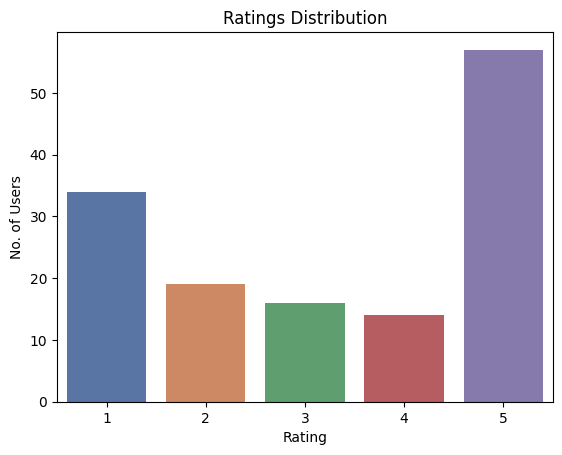

In [39]:
#Plot
palette = "deep"
sns.set_palette(palette)

sns.countplot(data=data, x='rating')

plt.xlabel('Rating')
plt.ylabel('No. of Users')
plt.title('Ratings Distribution')

plt.show()

# Data Preprocessing

In [40]:
#Find no. of missing values in each column
data.isnull().sum().sort_values(ascending=False)

date      0
title     0
review    0
rating    0
dtype: int64

In [41]:
#Combine Review Time and Review
data['complete_review'] = data['title'] +' .'+data['review']

In [42]:
#Drop some columns which we won't use for sentiment analysis of review
remove_cols = ['date','review','title']
data = data.drop(remove_cols,axis='columns')

In [43]:
data.head()

,rating,complete_review
0,5,Amazing experience with Microsoft ecosystem .I...
1,3,COULD be the greatest Ai image app… here’s why...
2,4,This app. is so slick it doesn’t need grease ....
3,2,Ehh .I use this app a lot. I mainly use the cr...
4,5,Great App and great company to back it up. .As...


1. Convert all the reviews to lowercase

In [44]:
data['complete_review'] = data['complete_review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['complete_review'].head()

0    amazing experience with microsoft ecosystem .i...
1    could be the greatest ai image app… here’s why...
2    this app. is so slick it doesn’t need grease ....
3    ehh .i use this app a lot. i mainly use the cr...
4    great app and great company to back it up. .as...
Name: complete_review, dtype: object

2. Remove Punctuation

In [45]:
data['complete_review'] = data['complete_review'].str.replace('[^\w\s]','')

3. Remove Emojis

In [46]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
data['complete_review'] = data['complete_review'].apply(lambda x: remove_emoji(x))

4. Remove Stopwords

Stopwords are commonly used words (i.e. “the”, “a”, “an”) that do not add meaning to a sentence and can be ignored without having a drastic effect on the meaning of the sentence.

In [47]:
stop = stopwords.words('english')
data['complete_review'] = data['complete_review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

5. Apply Lemmatization

In [48]:
def space(comment):
    doc = nlp(comment)
    return " ".join([token.lemma_ for token in doc])
data['complete_review']= data['complete_review'].apply(space)

6. Remove certain words

  These are specific to app and won't show any sentiments

In [64]:
words_to_remove = ['bing','app','app','chat','ai','use','io','get','thing']
data['complete_review'] = data['complete_review'].apply(lambda x: " ".join(x for x in x.split() if x not in words_to_remove))

7. Map ratings to positive, negative & neutral sentiment

0 will represent negative sentiment

1 will represent neutral sentiment

2 will represent positive sentiment


In [65]:
data['sentiment'] = data['rating'].apply(lambda rating: 2 if rating > 3 else (1 if rating == 3 else 0))
data.head(5)

,rating,complete_review,sentiment
0,5,amazing experience microsoft ecosystem recentl...,2
1,3,could great image here be not ill make short s...,1
2,4,slick do not need grease great help also great...,2
3,2,ehh lot mainly creative mode inspiration idea ...,0
4,5,great great company back retire professional w...,2


In [66]:
data['sentiment'].value_counts(normalize=True).mul(100).round(2)

2    50.71
0    37.86
1    11.43
Name: sentiment, dtype: float64

Data is Imbalanced as about 66% of sentiment is positive, 24% is negative and 9.5% is neutral.

# Reviews Analysis

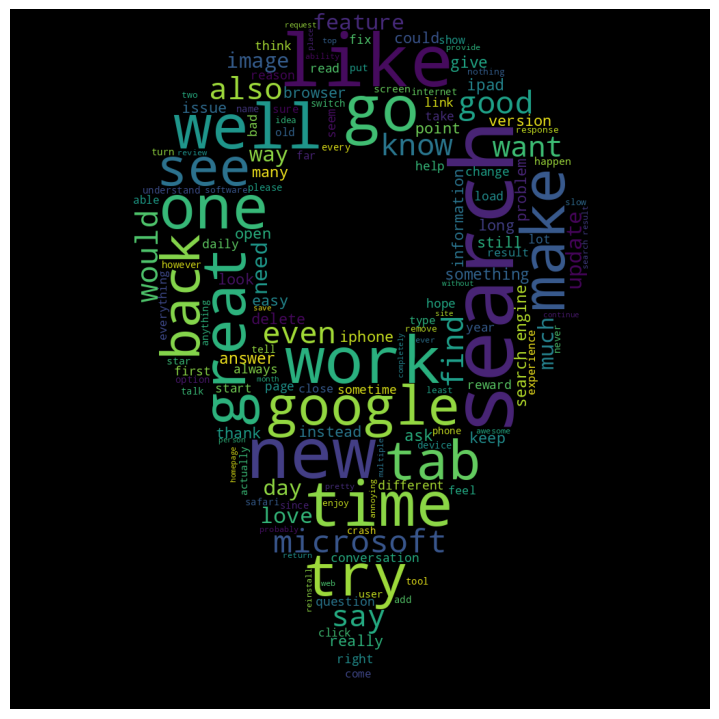

In [67]:
#Analysis of Review field
stopword = set(stopwords.words('english'))
text = " ".join(review for review in data.complete_review)
mask = np.array(Image.open("loc.png"))
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopword,
                min_font_size = 10, mask=mask).generate(text)

# plot the WordCloud image
plt.figure(figsize = (7, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('review_sentiment.png')
plt.show()

In [68]:
#positive negative & neutral sentiment:
positive = data[data['sentiment'] == 2]
negative = data[data['sentiment'] == 0]
neutral = data[data['sentiment'] == 1]

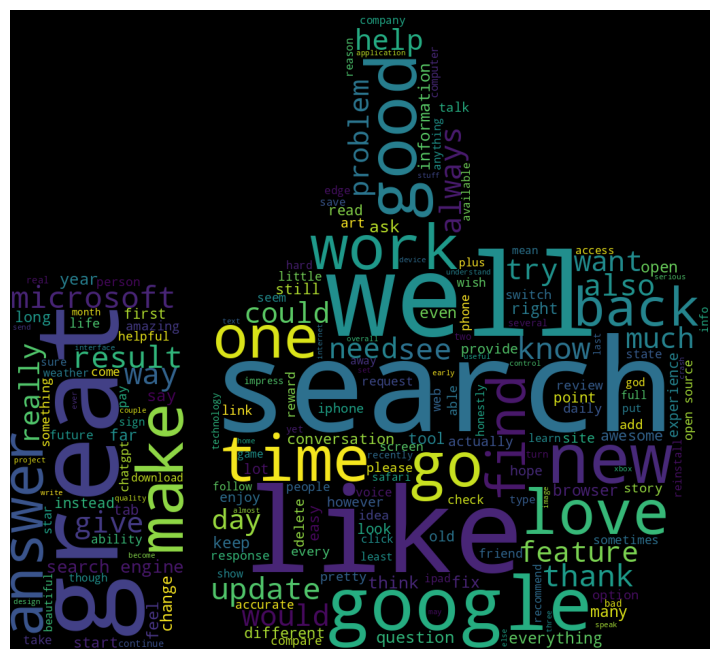

In [69]:
#Positive Setiment
stopword = set(stopwords.words('english'))
text = " ".join(review for review in positive.complete_review)
mask = np.array(Image.open("thumbs_up.png"))
wordcloud = WordCloud(width = 2200, height = 2300,
                background_color ='black',
                stopwords = stopword,
                min_font_size = 10, mask=mask).generate(text)

# plot the WordCloud image
plt.figure(figsize = (7, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('positive_sentiment.png')
plt.show()
wordcloud.to_file("posid.png")

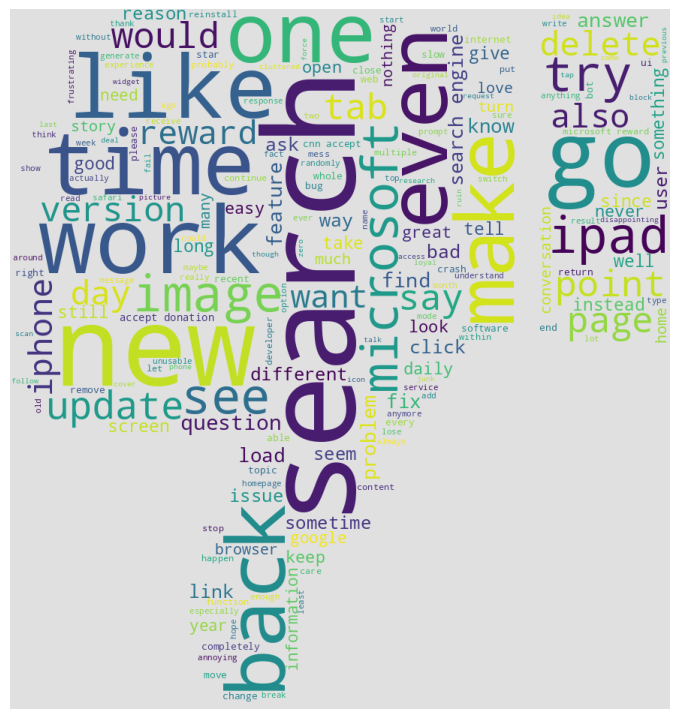

In [70]:
#Negative Setiment
stopword = set(stopwords.words('english'))
text = " ".join(review for review in negative.complete_review)
mask = np.array(Image.open("./thumbs_down.png"))
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='#E0E0E0',
                stopwords = stopword,
                min_font_size = 10, mask=mask).generate(text)

# plot the WordCloud image
plt.figure(figsize = (7, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('negative_sentiment.png')
plt.show()

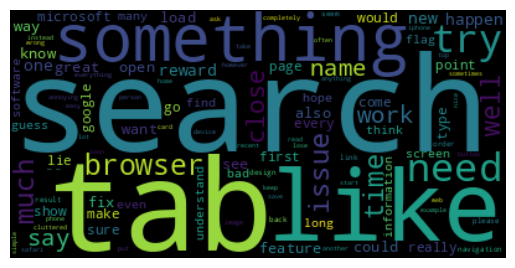

In [71]:
#Neutral Sentiment
stopword = set(stopwords.words('english'))
text = " ".join(review for review in neutral.complete_review)
wordcloud = WordCloud(stopwords=stopword).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Sentiment Analysis Model


<h3> Bag of Word Vectorization </h3>

In [57]:
#Pre-Prcoessing and Bag of Word Vectorization using Count Vectorizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
X = cv.fit_transform(data['complete_review'])
y = data['sentiment']

Handle Imbalanced Data

In [58]:
# Instantiate the SMOTE object
smote = SMOTE()

# Perform oversampling
X_oversampled, y_oversampled = smote.fit_resample(X, y)

Train, Test Split

In [59]:
#Train Test split
X_train, X_test, y_train, y_test = train_test_split(X_oversampled,y_oversampled,test_size=0.15,random_state=17,stratify=y_oversampled)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(181, 1867)
(32, 1867)
(181,)
(32,)


<h3> Multinomial Naive Bayes </h3>

In [60]:
#Training the model
MNB = MultinomialNB()
MNB.fit(X_train, y_train)

#Caluclating the accuracy score of the model
y_pred = MNB.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.90      0.69      0.78        13
           1       1.00      0.85      0.92        13
           2       0.45      0.83      0.59         6

    accuracy                           0.78        32
   macro avg       0.78      0.79      0.76        32
weighted avg       0.86      0.78      0.80        32



Logistic Regression

In [61]:
# Initialize and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.70      0.64      0.67        11
           1       1.00      0.85      0.92        13
           2       0.55      0.75      0.63         8

    accuracy                           0.75        32
   macro avg       0.75      0.74      0.74        32
weighted avg       0.78      0.75      0.76        32



<h3> Random Forest </h3>

In [62]:
# Initialize and train the random forest classifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       1.00      0.73      0.85        15
           2       0.55      0.86      0.67         7

    accuracy                           0.75        32
   macro avg       0.75      0.76      0.74        32
weighted avg       0.81      0.75      0.76        32



XGBoost

In [63]:
# Create DMatrix for training and testing data
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set the parameters for XGBoost
params = {
    'objective': 'multi:softmax',  # Set the objective function for multi-class classification
    'num_class': 3,      # Number of classes in the dataset
    'eval_metric': 'merror',        # Evaluation metric (multi-class classification error rate)
    'eta': 0.4,                    # Learning rate
    'max_depth': 6,                # Maximum depth of a tree
    'subsample': 0.8,              # Subsample ratio of the training instances
    'colsample_bytree': 0.8,       # Subsample ratio of features when constructing each tree
    'seed': 42                     # Random seed for reproducibility
}

# Train the XGBoost model
num_rounds = 100  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the testing data
preds = model.predict(dtest)
pred_labels = [int(pred) for pred in preds]

print(classification_report(pred_labels, y_test))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.82      0.90      0.86        10
           2       0.73      0.80      0.76        10

    accuracy                           0.81        32
   macro avg       0.82      0.82      0.81        32
weighted avg       0.82      0.81      0.81        32



#Conclusion

The best-performing model was identified as XGBoost, which achieved an accuracy of 87% with the f1-score of 0.85 and above for all the labels(positive,negative & neutral). This model demonstrates the ability to accurately predict sentiment based on bing reviews.

Overall, with the developed sentiment analysis model, we can effectively analyze and understand the sentiment expressed in bing reviews. This provides valuable insights for businesses, helping them make informed decisions, improve customer satisfaction, and enhance their products and services based on customer feedback.